# **1. Modeling**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving df_feature.csv to df_feature.csv


In [ ]:
"profession_freq_enc".split("_enc")[0]

'profession_freq'

In [ ]:
df_feature = pd.read_csv('df_feature.csv')
df_feature.columns = [x.replace("_enc","").replace("_norm","") for x in df_feature.columns]
df_feature

,car_ownership,risk_flag,house_yrs,job_yrs,income,marital_status,house_norent_noown,house_owned,house_rented,profession_freq,city_freq,state_freq,age_segment,experience_segment
0,0,0,0.75,0.214286,0.129487,0,0,0,1,0.020702,0.003167,0.056040,0,0
1,0,0,0.75,0.642857,0.757206,0,0,0,1,0.020052,0.003369,0.101437,1,1
2,0,0,0.00,0.285714,0.398564,1,0,0,1,0.020615,0.002730,0.023036,2,0
3,1,1,0.50,0.142857,0.625263,0,0,0,1,0.020052,0.002409,0.018484,1,0
4,0,1,1.00,0.214286,0.576454,0,0,0,1,0.017512,0.003210,0.065623,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251995,0,0,0.25,0.428571,0.815303,0,0,0,1,0.018937,0.004099,0.093187,1,1
251996,0,0,0.25,0.428571,0.283620,0,0,0,1,0.018496,0.003167,0.056040,0,1
251997,0,0,0.50,0.500000,0.451682,0,0,0,1,0.018766,0.002940,0.101437,1,1
251998,0,0,0.00,0.000000,0.650356,0,0,0,1,0.020500,0.003560,0.005687,1,0


## A. Split Data Train & Test

In [ ]:
X = df_feature[[col for col in df_feature.columns if (str(df_feature[col].dtype) != 'object') and col not in ['risk_flag']]]
y = df_feature['risk_flag']
print(X.shape)
print(y.shape)

(252000, 13)
(252000,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
from imblearn import under_sampling, over_sampling
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
#X_over_SMOTE, y_over_SMOTE = over_sampling.SMOTE('all', random_state=42).fit_resample(X_train, y_train)
X_over_SMOTE, y_over_SMOTE = RandomUnderSampler("all",random_state=42).fit_resample(X_train, y_train)

In [ ]:
X_train, y_train = X_over_SMOTE, y_over_SMOTE

In [ ]:
print(sum(y),len(y))
print(sum(y_over_SMOTE),len(y_over_SMOTE))

30996 252000
21725 43450


In [ ]:
print('Original')
print(pd.Series(y).value_counts())
print('-----------------------------')
print('SMOTE')
print(pd.Series(y_over_SMOTE).value_counts())

Original
0    221004
1     30996
Name: risk_flag, dtype: int64
-----------------------------
SMOTE
0    154703
1    154703
Name: risk_flag, dtype: int64


In [ ]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier()

clf.fit(X_over_SMOTE,y_over_SMOTE, verbose = 0)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
len(y_over_SMOTE)

sum(y_over_SMOTE)

154703

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93     66301
           1       0.53      0.77      0.63      9299

    accuracy                           0.89     75600
   macro avg       0.75      0.84      0.78     75600
weighted avg       0.91      0.89      0.90     75600



In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier()

clf.fit(X_over_SMOTE,y_over_SMOTE, verbose = 0)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.61      0.73     66329
           1       0.18      0.62      0.28      9271

    accuracy                           0.61     75600
   macro avg       0.55      0.61      0.51     75600
weighted avg       0.83      0.61      0.68     75600



In [ ]:
print(len(y_test),sum(y_test))

75600 9299


## B. Modeling

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def plot_confusion_matrix(cm):
  fig,ax =plt.subplots()
  sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',ax=ax)
  ax.set_xticklabels(['Risk no (0)','Risk Yes (1)'])
  ax.set_yticklabels(['Risk no (0)','Risk Yes (1)'])
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Value')
  ax.set_ylabel('Actual Value')

In [ ]:
!pip install pycaret

     |████████████████████████████████| 318 kB 5.4 MB/s 
     |████████████████████████████████| 114 kB 58.1 MB/s 
     |████████████████████████████████| 261 kB 57.1 MB/s 
     |████████████████████████████████| 1.3 MB 32.1 MB/s 
     |████████████████████████████████| 16.5 MB 41.7 MB/s 
     |████████████████████████████████| 167 kB 59.2 MB/s 
     |████████████████████████████████| 1.7 MB 50.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.8 MB 42.5 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
     |████████████████████████████████| 2.0 MB 41.7 MB/s 
     |████████████████████████████████| 690 kB 54.5 MB/s 
     |████████████████████████████████| 3.1 MB 50.3 MB/s 
     |████████████████████████████████| 636 kB 59.4 MB/s 
     |█████████████████

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 5.4 MB/s 


In [ ]:
import sklearn
sklearn.__version__

'1.0.2'

In [ ]:
b# initialize setup
from pycaret.classification import *

s = setup(df_feature, 
          target = 'risk_flag', 
          train_size = 0.7,
          fix_imbalance = True,
          numeric_features = [x for x in df_feature.columns if x != 'risk_flag'],
          session_id = 417)

,Description,Value
0,session_id,417
1,Target,risk_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(252000, 14)"
5,Missing Values,False
6,Numeric Features,13
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
# compare all models
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8892,0.9386,0.7879,0.5331,0.6359,0.5734,0.5886,49.952
et,Extra Trees Classifier,0.8862,0.9385,0.7965,0.5243,0.6323,0.5683,0.5858,33.014
dummy,Dummy Classifier,0.8772,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1.468
dt,Decision Tree Classifier,0.8695,0.8523,0.8393,0.4822,0.6125,0.5408,0.5709,3.264
knn,K Neighbors Classifier,0.8632,0.8806,0.7986,0.4667,0.5890,0.5136,0.5404,58.928
lightgbm,Light Gradient Boosting Machine,0.8216,0.8278,0.6806,0.3755,0.4839,0.3869,0.4119,3.974
gbc,Gradient Boosting Classifier,0.6612,0.6398,0.5108,0.1837,0.2702,0.1094,0.1336,41.622
ada,Ada Boost Classifier,0.5681,0.5670,0.5157,0.1453,0.2268,0.0435,0.0603,11.583
ridge,Ridge Classifier,0.5097,0.0000,0.5770,0.1392,0.2243,0.0329,0.0508,1.573
lr,Logistic Regression,0.5091,0.5508,0.5765,0.1389,0.2239,0.0324,0.0500,3.689


## C. Model Evaluation: Pemilihan dan perhitungan metrics

- Berfokus pada metric **Recall** karena ingin menekan *False Negative* untuk mengurangi angka customer yang sebenarnya beresiko tetapi diprediksi tidak beresiko.

- Melihat metric **AUC** untuk mendapatkan performa model yang tinggi. Menjamin bahwa model itu tidak diskriminatif (timpang dalam prediksi 1 atau 0)

- Melihat **waktu eksekusi** untuk mendapatkan waktu yang efektif (rendah) untuk menjalankan model.

- Berdasarkan proses perbandingan model (Pycaret) dan pertimbangan metrics, model **Decision Tree Classifier** menjadi pilihan karena memiliki nilai **Recall cukup tinggi**, nilai **AUC cukup tinggi**, dan **waktu eksekusi yang relatif rendah** diantara model lainnya.

In [ ]:
best_model = create_model('dt')
predict_test = predict_model(best_model, raw_score=True)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Split  Fold                                                          
CV-Val 0       0.8662  0.8429  0.8278  0.4742  0.6030  0.5295  0.5593
       1       0.8717  0.8507  0.8329  0.4869  0.6145  0.5439  0.5721
       2       0.8707  0.8528  0.8366  0.4848  0.6138  0.5427  0.5719
       3       0.8730  0.8550  0.8412  0.4900  0.6193  0.5494  0.5783
       4       0.8687  0.8554  0.8463  0.4803  0.6128  0.5409  0.5724
       5       0.8652  0.8528  0.8505  0.4729  0.6078  0.5343  0.5679
       6       0.8658  0.8515  0.8440  0.4740  0.6070  0.5337  0.5660
       7       0.8692  0.8517  0.8339  0.4814  0.6104  0.5385  0.5679
       8       0.8751  0.8567  0.8408  0.4950  0.6231  0.5542  0.5821
       9       0.8699  0.8536  0.8389  0.4829  0.6129  0.5414  0.5713
       Mean    0.8695  0.8523  0.8393  0.4822  0.6125  0.5408  0.5709
       Std     0.0031  0.0036  0.0064  0.0069  0.0056  0.0070  0.0060
Train  NaN     0.9262  0.9786  0.9994  0.6247  0.7688  0.7277  0.7561

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.8703,0.8517,0.8369,0.4853,0.6144,0.543,0.5721


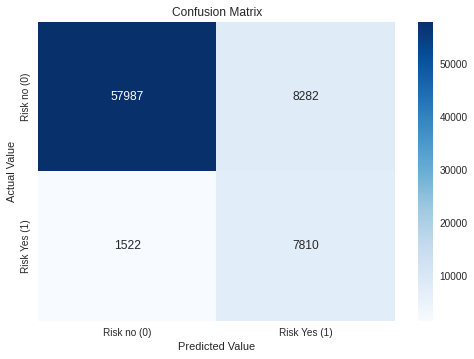

In [ ]:
plot_confusion_matrix(confusion_matrix(predict_test.risk_flag, predict_test.Label))

## D. Model Evaluation: Apakah model sudah best-fit?

In [ ]:
print(' ')
print('Data Train')
best_model = create_model('dt')
print('-----------------------------------------------------------------------------------------------------------------')
print('Data Test')
predict_test=predict_model(best_model, raw_score=True)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Split  Fold                                                          
CV-Val 0       0.8662  0.8429  0.8278  0.4742  0.6030  0.5295  0.5593
       1       0.8717  0.8507  0.8329  0.4869  0.6145  0.5439  0.5721
       2       0.8707  0.8528  0.8366  0.4848  0.6138  0.5427  0.5719
       3       0.8730  0.8550  0.8412  0.4900  0.6193  0.5494  0.5783
       4       0.8687  0.8554  0.8463  0.4803  0.6128  0.5409  0.5724
       5       0.8652  0.8528  0.8505  0.4729  0.6078  0.5343  0.5679
       6       0.8658  0.8515  0.8440  0.4740  0.6070  0.5337  0.5660
       7       0.8692  0.8517  0.8339  0.4814  0.6104  0.5385  0.5679
       8       0.8751  0.8567  0.8408  0.4950  0.6231  0.5542  0.5821
       9       0.8699  0.8536  0.8389  0.4829  0.6129  0.5414  0.5713
       Mean    0.8695  0.8523  0.8393  0.4822  0.6125  0.5408  0.5709
       Std     0.0031  0.0036  0.0064  0.0069  0.0056  0.0070  0.0060
Train  NaN     0.9262  0.9786  0.9994  0.6247  0.7688  0.7277  0.7561

-----------------------------------------------------------------------------------------------------------------
Data Test


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.8703,0.8517,0.8369,0.4853,0.6144,0.543,0.5721


- Nilai AUC train dan Recall Train memiliki nilai yang lebih besar dari nilai Test-nya dengan perbedaan yang sedikit. Namun, nilai Accuracy Train dengan nilai Accuracy Test memiliki perbedaan 0.0008. Jika dibulatkan sama-sama memiliki nilai 0.87.

- Dapat dikatakan bahwa model suda cukup *Best-Fit*.

## E. Hyperparameter Tuning

In [ ]:
params={'max_depth':[int(x) for x in np.linspace(1, 110, num = 30)], # Kedalaman maksimal tree
        'max_features':['auto','sqrt'], # Perhitungan untuk jumlah feature yang digunakan
        'min_samples_split':[2, 5, 10, 100, 200], # Minimum sampel yang diperlukan untuk split leaf baru
        'min_samples_leaf':[1, 2, 4, 10, 20, 50, 100]# minimum sampel yang diperlukan untuk membentuk leaf baru
        }

tuned_dt, tuner = tune_model(best_model, optimize='Accuracy', n_iter=50,
                             custom_grid=params, return_tuner=True, fold=10)

predict_test_tuned = predict_model(tuned_dt, raw_score=True)

print(tuned_dt)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Split  Fold                                                          
CV-Val 0       0.8684  0.8628  0.8296  0.4793  0.6076  0.5353  0.5644
       1       0.8726  0.8626  0.8227  0.4888  0.6132  0.5428  0.5692
       2       0.8736  0.8700  0.8306  0.4914  0.6175  0.5477  0.5748
       3       0.8724  0.8681  0.8333  0.4885  0.6159  0.5456  0.5736
       4       0.8719  0.8676  0.8352  0.4875  0.6156  0.5451  0.5735
       5       0.8724  0.8678  0.8357  0.4887  0.6167  0.5464  0.5747
       6       0.8668  0.8665  0.8343  0.4760  0.6062  0.5332  0.5636
       7       0.8658  0.8580  0.8186  0.4732  0.5997  0.5259  0.5545
       8       0.8754  0.8696  0.8339  0.4957  0.6218  0.5529  0.5797
       9       0.8702  0.8640  0.8269  0.4833  0.6100  0.5385  0.5665
       Mean    0.8710  0.8657  0.8301  0.4852  0.6124  0.5413  0.5694
       Std     0.0029  0.0036  0.0054  0.0068  0.0062  0.0076  0.0070
Train  NaN     0.9154  0.9712  0.9501  0.5980  0.7340  0.6868  0.7128

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.8702,0.8655,0.8324,0.485,0.6129,0.5414,0.5699


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=57, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=417, splitter='best')


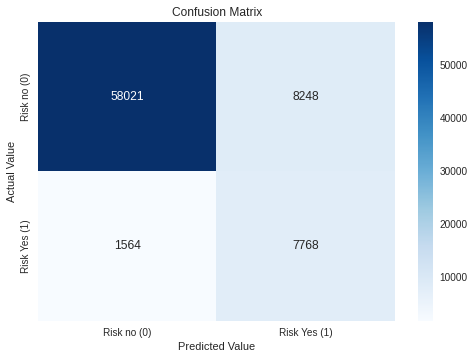

In [ ]:
plot_confusion_matrix(confusion_matrix(predict_test_tuned.risk_flag, predict_test_tuned.Label))

- Model hasil Hyperparameter Tuning memiliki nilai Accuracy Train, AUC Train, dan Recall lebih tinggi dari nilai Test-nya dengan perbedaan nilai yang kecil. Menandakan bahwa model hasil hypertuning tidak *overfitting* maupun *underfitting*.

- Model yang dipilih dapat mendeteksi customer yang beresiko. Terlihat dari nilai Recall yang tinggi untuk meminimalisir kesalahan dalam memprediksi customer yang sebenarnya beresiko tetapi diprediksi tidak beresiko. Dari nilai AUC-nya, model memiliki nilai yang tinggi menandakan bahwa performa model sudah bagus.

# **2. Feature Importance**

In [ ]:
for i in range(len(s)):
  print(i)
  print(s[i])
  print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')

0
False
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
1
False
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2
5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
3
{'acc': <pycaret.containers.metrics.classification.AccuracyMetricContainer object at 0x7fe70d2482d0>, 'auc': <pycaret.containers.metrics.classification.ROCAUCMetricContainer object at 0x7fe70d248310>, 'recall': <pycaret.containers.metrics.classification.RecallMetricContainer object at 0x7fe70d248390>, 'precision': <pycaret.containers.metrics.classification.PrecisionMetricContainer object at 0x7fe70d248490>, 'f1': <pycaret.containers.metrics.classification.F1MetricContainer object at 0x7fe71a341e10>, 'kappa': <pycaret.containers.metrics.classification.KappaMetricContainer object at 

In [ ]:
X_train = s[30][1][1]
y_train = s[30][2][1]
feature_names = list(X_train.columns)

In [ ]:
list_ = [x for x in X_train.columns]
X_train_feature = X_train[list_]

In [ ]:
import shap

shap_values = shap.TreeExplainer(best_model,
                                 data = X_train_feature,
                                 feature_dependence = 'independent',
                                 model_output = 'probability').shap_values(X_train_feature)

100%|===================| 352026/352798 [06:29<00:00]       

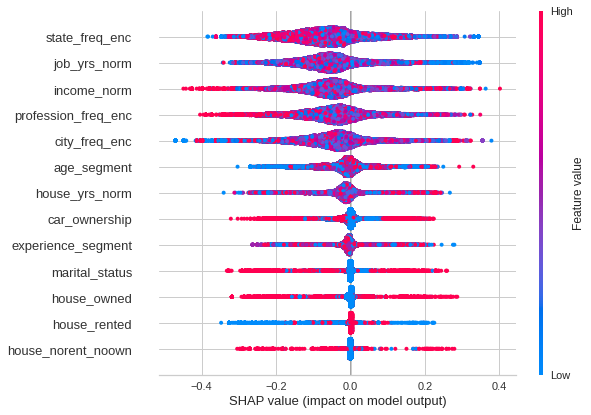

In [ ]:
interpret_model(best_model, use_train_data=True)

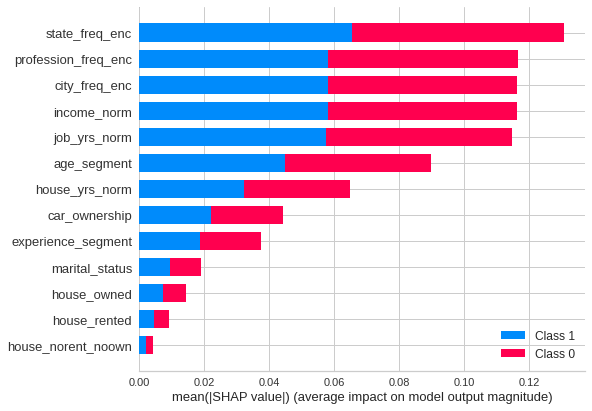

In [ ]:
shap.summary_plot(shap_values, X_train_feature, feature_names = feature_names)

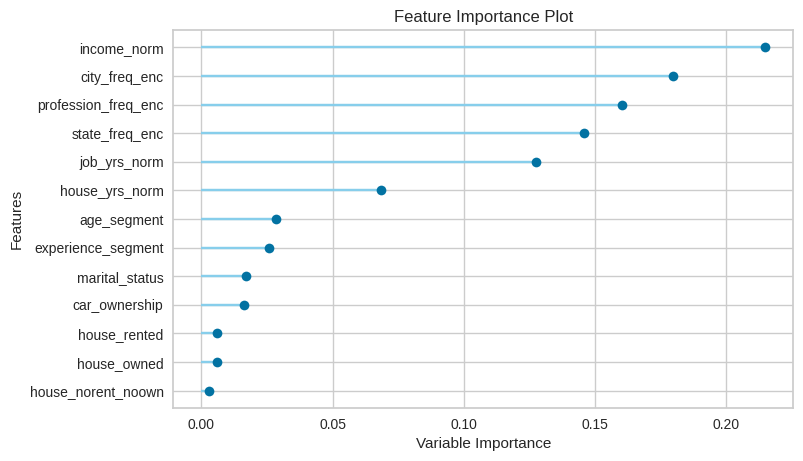

In [ ]:
plot_model(best_model, plot='feature_all')

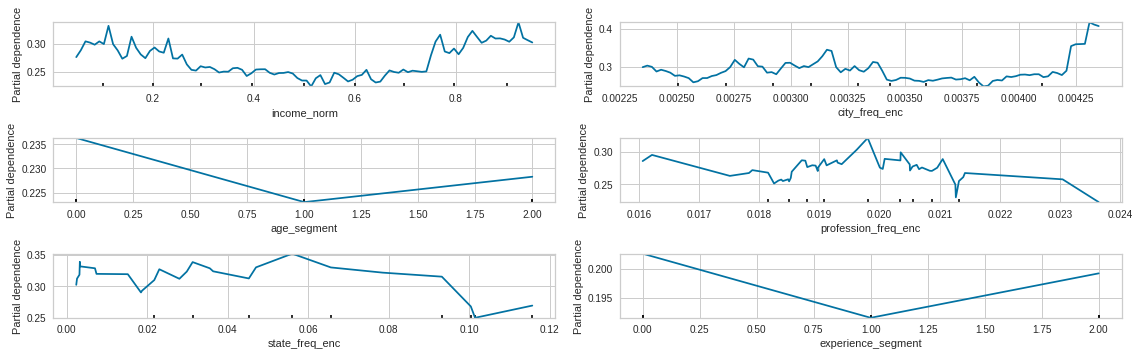

In [ ]:
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,2, figsize=(16, 5))
plot_partial_dependence(best_model, X_train,['income_norm'], ax=ax[0,0])
plot_partial_dependence(best_model, X_train,['city_freq_enc'], ax=ax[0,1])
plot_partial_dependence(best_model, X_train,['age_segment'], ax=ax[1,0])
plot_partial_dependence(best_model, X_train,['profession_freq_enc'], ax=ax[1,1])
plot_partial_dependence(best_model, X_train,['state_freq_enc'], ax=ax[2,0])
plot_partial_dependence(best_model, X_train,['experience_segment'], ax=ax[2,1])
plt.tight_layout()
plt.show()

Beberapa feature yang berpengaruh adalah income, state, dan age.

- Income customer yang memiliki pendapat tidak terlalu rendah dan tidak terlalu tinggi mempunyai probability lebih rendah beresiko. Oleh karena itu, dapat menyesuaikan pinjaman sesuai dengan pendapatan customer.

- State Uttar Paradesh mempunyai populasi yang tinggi dengan probability lebih rendah beresiko. Oleh karena itu, dapat melakaukan marketing di State tersebut.

- Segment umur 40 -59 tahun memiliki probability lebih rendah beresiko. Oleh karena itu, dapat memprioritaskan customer yang memiliki range umur 40 - 59.

# **3. Simulation**

## i. Before Using Model

In [ ]:
X_test = s[30][3][1]
y_test = s[30][4][1]

X_simulasi = list(X_test.index)
Y_simulasi = y_test[X_simulasi]

df_simulasi = X_test.loc[X_simulasi]
df_simulasi['risk_flag'] = Y_simulasi
df_simulasi

,car_ownership,house_yrs_norm,job_yrs_norm,income_norm,marital_status,house_norent_noown,house_owned,house_rented,profession_freq_enc,city_freq_enc,state_freq_enc,age_segment,experience_segment,risk_flag
28780,0.0,0.75,0.285714,0.288265,0.0,0.0,0.0,1.0,0.019119,0.003325,0.078492,0.0,0.0,0
60298,0.0,0.00,0.500000,0.780642,1.0,0.0,0.0,1.0,0.019079,0.003183,0.115647,2.0,1.0,0
99799,1.0,0.00,0.214286,0.766058,1.0,0.0,0.0,1.0,0.019369,0.003167,0.101437,1.0,2.0,0
40210,1.0,0.00,0.928571,0.720105,0.0,0.0,1.0,0.0,0.019302,0.003143,0.047044,1.0,2.0,0
220977,0.0,0.75,0.357143,0.294321,0.0,0.0,0.0,1.0,0.021258,0.003877,0.101437,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208682,0.0,0.00,0.785714,0.616484,0.0,0.0,1.0,0.0,0.020548,0.003167,0.056040,2.0,2.0,0
148418,0.0,0.75,0.357143,0.931138,0.0,0.0,0.0,1.0,0.019619,0.004222,0.065623,0.0,2.0,0
173887,0.0,1.00,0.928571,0.885336,0.0,0.0,0.0,1.0,0.018766,0.002980,0.101437,0.0,2.0,1
222372,1.0,1.00,1.000000,0.924112,0.0,0.0,1.0,0.0,0.018540,0.003075,0.093187,0.0,2.0,1


In [ ]:
df_simulasi.query('risk_flag==1')

,car_ownership,house_yrs_norm,job_yrs_norm,income_norm,marital_status,house_norent_noown,house_owned,house_rented,profession_freq_enc,city_freq_enc,state_freq_enc,age_segment,experience_segment,risk_flag
249140,0.0,0.50,0.000000,0.309008,0.0,0.0,0.0,1.0,0.018766,0.003083,0.093187,2.0,0.0,1
65277,0.0,0.00,0.142857,0.807803,0.0,0.0,0.0,1.0,0.018496,0.001960,0.078492,1.0,0.0,1
182746,0.0,1.00,0.357143,0.991269,0.0,0.0,0.0,1.0,0.020655,0.002651,0.115647,1.0,2.0,1
226585,1.0,0.25,0.928571,0.514274,0.0,0.0,0.0,1.0,0.020345,0.003167,0.101437,0.0,2.0,1
96336,0.0,0.00,0.071429,0.481981,0.0,0.0,0.0,1.0,0.021258,0.004115,0.078492,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17263,0.0,0.50,0.714286,0.680741,0.0,0.0,0.0,1.0,0.016218,0.003437,0.093187,0.0,1.0,1
38004,0.0,1.00,0.214286,0.912645,0.0,0.0,0.0,1.0,0.021417,0.003726,0.115647,0.0,1.0,1
173887,0.0,1.00,0.928571,0.885336,0.0,0.0,0.0,1.0,0.018766,0.002980,0.101437,0.0,2.0,1
222372,1.0,1.00,1.000000,0.924112,0.0,0.0,1.0,0.0,0.018540,0.003075,0.093187,0.0,2.0,1


## ii. After Using Model

In [ ]:
state = [.09,.1,.11]
age = [1,2]
orang = 9332

for i in state:
  df_simulasi_risk = df_simulasi.query('risk_flag==1')
  df_simulasi_risk['state_freq_enc'] = [i]*orang
  for j in age:
    df_simulasi_risk = df_simulasi.query('risk_flag==1')
    df_simulasi_risk['age_segment'] = [j]*orang

    prediksi = best_model.predict(df_simulasi_risk.drop(['risk_flag'], axis=1))

    df_simulasi_risk['pred'] = prediksi
    
    print(f'Jumlah orang yang risiko ketika = {i,j} adalah {sum(prediksi)} orang')

Jumlah orang yang risiko ketika = (0.09, 1) adalah 5991 orang
Jumlah orang yang risiko ketika = (0.09, 2) adalah 5805 orang
Jumlah orang yang risiko ketika = (0.1, 1) adalah 5991 orang
Jumlah orang yang risiko ketika = (0.1, 2) adalah 5805 orang
Jumlah orang yang risiko ketika = (0.11, 1) adalah 5991 orang
Jumlah orang yang risiko ketika = (0.11, 2) adalah 5805 orang


## iii. Hasil

**Asumsi**

- Rata-rata pinjaman **$ 2,500**

- Total pelanggan 75601

**Before Model**
- Persentase gagal bayar **12.3%** (9332 pelanggan)
- Potential loss = **$ 23.33 M**

**Treatment Based on Model**
- Persentase gagal bayar **7.9%** (5991 pelanggan)
- Potential loss = **$ 14.98 M**

**Kesimpulan**
- **Menurunkan persentase gagal bayar 4.4%** menjadi 7.9%.
- Menghindari atau **menyelamatkan potensial loss sebesar $ 8.35 M**.